In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import random

In [147]:
class Circuit:
    def __init__(self,n):
        self.n = n
        self.wires = [Wire(k) for k in range(n)]
        self.gates = []
        
    def addGate(self,g):
        self.gates.append(g)
        for bit in g.bits:
            self.wires[bit].addGate(g)
            
    def appendCircuit(self,circuit, offset=0):
        if offset == 0:
            for gate in circuit.gates:
                self.addGate(gate)
        else:
            pass
    
    def __str__(self):
        string = ""
        for gate in self.gates:
            string = string + str(gate)
            
        return string
        
    def fullStoch(self,state=[]):
        if state == []:
            state = np.zeros(self.n)
        state = state2dist(self.n,state)
        for gate in self.gates:
            state = gate.fullStoch(self.n) @ state
        return state
    
    
    def printWires(self):
        for wire in self.wires:
            print(wire)
            
    def fireShot(self,state=[]):
        if state == []:
            state = np.zeros(self.n)
            
        for gate in self.gates:
            gate_state = [state[b] for b in gate.bits]
            gate_state = gate.fireLocal(gate_state)
            for i in range(len(gate_state)):
                state[gate.bits[i]] = gate_state[i]
        return state
        
    def expectationShots(self, numshots):
        assert(numshots > 0), "invalid number of shots, must be more than 0"
        runningtotal = self.fireShot()
        for i in range(numshots-1):
            runningtotal = runningtotal + self.fireShot()
        
        return [x / numshots for x in runningtotal]
    
    def shotsDist(self, numshots):
        assert(numshots > 0), "invalid number of shots, must be more than 0"
        histstates = {}
        for i in range(numshots):
            state = self.fireShot()
            ind = 0
            for k in range(len(state)):
                ind += 2**k * state[k] 
            ind = int(ind)
            if ind in histstates:
                histstates[ind] += 1
            else:
                histstates[ind] = 1
        for k in histstates:
            histstates[k] /= numshots
        return histstates
    
    def shotsDistHist(self, numshots):
        assert(numshots > 0), "invalid number of shots, must be more than 0"
        histstates = np.zeros(2**self.n)
        xs = np.zeros(2**self.n)
        
        for i in range(numshots):
            state = self.fireShot()
            ind = 0
            for k in range(len(state)):
                 ind += 2**k * state[k] 
            histstates[ind] += 1
            xs[ind] = ind
        hist = plt.bar(xs,histstates)
        return hist
        
class Wire:
    def __init__(self,k):
        self.k = k
        self.gates = []
    
    def addGate(self,g):
        self.gates.append(g)
    
    def removeLastGate(self):
        return self.gates.pop()
    
    def __str__(self):
        string = f"[{self.k}]:"
        for gate in self.gates:
            string += str(gate)
        return string

class Gate:
    #assumes if bits = (0,1,2), order is kron(b2,b1,b0).  This follows from c01 gate having control
    #on 0 and target on 1 by convention
    gatecount = 0

    def __init__(self,matrix,bits):
        assert(matrix.shape == (2**len(bits),2**len(bits)))
        self.matrix = matrix
        self.bits = bits
        self.id = Gate.gatecount
        Gate.gatecount += 1
        
    def __str__(self):
        return f"-g{self.id}-"
    
    
    def fireLocal(self,state):
        #TODO: verify that this is resilient to weird ordered qubits
        state_dist = state2dist(len(state),state)
        new_dist = np.dot(self.matrix,state_dist);
        new_state = sampledist(len(state),new_dist)
        return new_state;
    
    def fullStoch(self,n):
        #TODO: optimize for adjacent bit states (no swaps required)
        #first construct hamiltonian operating on first len(bits) qubits, then swap bits to fit order
        stoch = self.matrix
        for i in range(n - len(self.bits)):
            stoch = np.kron([[1,0],[0,1]],stoch)
            
        swaps = Gate._swapcircuit(self,n)
        if len(swaps):
            stoch = np.dot(stoch, np.transpose(swaps))
            stoch = np.dot(swaps, stoch)
            
        return stoch
    
    def _swapcircuit(self,n):
        swaplist = Gate._bubbleSortOperations(self.bits) 
        sortedbits = sorted(self.bits)
        for i in range(len(sortedbits)-1,-1,-1):
            if not (i == sortedbits[i]):
                swaplist.append((i,sortedbits[i]))
        return Gate._swapStoch(self,n,swaplist)
    
    
    def _swapStoch(self,n,swaplist):
        swapMatrix =  []
        if not (len(swaplist) == 0):
            swapMatrix = np.eye(2**n)
            for swapbits in swaplist:
                swapMatrix = np.dot(Gate._generateSwapMatrix(n,swapbits),swapMatrix)
        return swapMatrix
    
    def _generateSwapMatrix(n,swapbits):
        N = 2**n
        swapMat = np.zeros((N,N))
        for i in range(N):
            mask1 = i >> swapbits[0] & 1
            mask2 = i >> swapbits[1] & 1
            xor = mask1 ^ mask2
            xor = xor << swapbits[0] | xor << swapbits[1]
            j = i ^ xor
            swapMat[i,j] = 1
        return swapMat
    
    def _bubbleSortOperations(bits):
        issorted = False
        swaplist = []
        while not issorted:
            issorted = True
            for i in range(len(bits) - 1):
                if bits[i] > bits[i+1]:
                    temp = bits[i]
                    bits[i] = bits[i+1]
                    bits[i+1] = temp
                    issorted = False
                    swaplist.append((i,i+1))
        return swaplist

def state2dist(n,state):
    ##reverse marginal calculation, assuming no correlation
    #state in form: [probBit0, probBit1, ..., probBitn] == ones(n)
    #simialr to a bit string
    #dist in form [probState0,probState1, ..., probStaten]
    #similar to quantum state
    dist = np.zeros(2**n)
    for i in range(2**n):
        iprob = 1;
        for k in range(n):
            if (1 << k) & i:
                iprob *= state[k]
            else:
                iprob *= 1.0 - state[k]
        dist[i] = iprob
    return dist
            
        
def dist2state(n,dist):
    ##Effectively a marginal calculation
    #dist in form [probState0,probState1, ..., probStaten]
    #similar to quantum state
    #state in form: [probBit0, probBit1, ..., probBitn] == ones(n)
    #similar to a bit string
    outstate = np.zeros(n);
    for i in range(2**n):
        for k in range(n):
            outstate[k] += (((1 << k) & i)>>k) * dist[i]
            
    return outstate
            
def sampledist(n,dist):
    choices = [i for i in range(2**n)]
    choice = np.random.choice(choices,p=dist)
    state = np.zeros(n)
    for i in range(n):
        state[i] += (((1 << i) & choice) >> i)
    return state

def randomStochMatrix(n):
    mat = np.random.rand(2**n,2**n)
    mat = mat/mat.sum(axis = 0)
    return mat

def stateHistogram(n,dist):
    assert (type(dist) == np.ndarray or type(dist) == dict), "Invalid type for plotting.  Must be np.ndarray or dict"
    if type(dist) == dict:
        xs = [k for k in dist]
        xs.sort()
        ys = [dist[k] for k in xs]
        fig, ax = plt.subplots()
        ax.bar(xs,ys)
        plt.title("Sampled Distribution")
        plt.xlabel("state")
        plt.ylabel("prob")
        
        xtickformat = '0' + str(n) + 'b'
        xticks = [str(format(x, xtickformat)) for x in xs]
        
        ax.set_xticks(range(len(xticks)))
        ax.set_xticklabels(xticks,rotation="vertical")
        return fig
    else:
        xs = dist.nonzero()
        ys = np.array(dist[xs])
        xs = xs[0]
        print(xs)
        print()
        print(ys)
        fig, ax = plt.subplots()
        ax.bar(xs,ys)
        plt.title("True Distribution")
        plt.xlabel("state")
        plt.ylabel("prob")
        
        xtickformat = '0' + str(n) + 'b'
        xticks = [str(format(x, xtickformat)) for x in xs]
        
        ax.set_xticks(range(len(xticks)))
        ax.set_xticklabels(xticks,rotation="vertical")
        return fig

def randomConnectedGraph(n):
    #returns a random connected 3-regular graph
    G = nx.generators.random_graphs.random_regular_graph(3,n)
    while not nx.is_connected(G):
        G = nx.generators.random_graphs.random_regular_graph(3,n);
        
    #relabelling to fix read/write issues (reads nodes in different order producing wrong
    #adjacency matrix)
    mapping = dict(zip(G,sorted(G)))
    G = nx.relabel_nodes(G, mapping)
    return G

def readGraph(path):
    file = open(path,'r')
    G = nx.Graph()
    for line in file:
        if line[0] == '#':
            continue
        else:
            line = line.strip('\n')
            labels = line.split(' ')
            G.add_node(int(labels[0]))
    file.seek(0)
    for line in file:
        if line[0] == '#':
            continue
        else:
            line = line.strip('\n')
            labels = line.split(' ')
            edges = [(int(labels[0]),int(labels[i])) for i in range(1,len(labels))]
            G.add_edges_from(edges)
    file.close()
    return G

def writeGraph(G,path):
    nx.write_adjlist(G,path)
    
def graphMatrix(G):
    return nx.adjacency_matrix(G)

def graphCutBin(G,vec):
    vec = np.array(vec)
    vec = 1 - 2*vec
    return graphCutIsing(G,vec);

def graphCutIsing(G,vec):
    #use mat.size instead of np.sum(mat) for speed. since all weights are 1 in matrix.
    vec = np.array([vec])
    mat = graphMatrix(G)
    return (mat.size - (vec @ mat @ vec.T)[0][0])/4

def getAnsatzGate2bit(b1,b2,gamma):
    P = np.array(\
        [[0,0,0,0 ],\
         [.5,1,0,.5],\
         [.5,0,1,.5],\
         [0,0,0,0]])
    mat = sp.linalg.expm(-gamma * (np.identity(4) - P))
    gate = Gate(mat,[b1,b2])
    return gate
    
def getAnsatzGate1bit(b,theta):
    mat = np.array([[np.cos(theta)**2, np.sin(theta)**2],[np.sin(theta)**2, np.cos(theta)**2]])
    gate = Gate(mat,[b])
    return gate

def getEdgeColoring(G):
    lineGraph = nx.generators.line.line_graph(G)
    colors = nx.algorithms.greedy_color(lineGraph)
    return colors

def colors2dict(colors):
    d = dict()
    for edge in colors.keys():
        if colors[edge] in d.keys():
            d[colors[edge]].append(edge)
        else:
            d[colors[edge]] = [edge]
    return d

def getEmbeddedCircuit(G,theta,gamma):
    colors = getEdgeColoring(G);
    colordict = colors2dict(colors)
    n = G.number_of_nodes()
    circ = Circuit(n)
    #TODO: Add capability of random shuffling of keys for random layer ordering
    #add coinflip gates
    for bit in range(n):
        gate = getAnsatzGate1bit(bit,theta)
        circ.addGate(gate)
    
    #add 2 pbit ansatz gates
    for color in colordict.keys():
        layerlist = colordict[color]
        for edge in layerlist:
            gate = getAnsatzGate2bit(*edge,gamma)
            circ.addGate(gate)
    
    return circ
    

Gates:
-g25--g26--g27-

Wires:
[0]:-g25--g27-
[1]:-g25--g26-
[2]:-g27-
[3]:
[4]:

Shot Distribution:
[0, 1, 2, 3, 4, 5, 6, 7]
00000  =>  0.0564
00001  =>  0.0805
00010  =>  0.0666
00011  =>  0.0929
00100  =>  0.0628
00101  =>  0.2601
00110  =>  0.0753
00111  =>  0.3054

True Distribution:
00000  =>  0.05689903902944693
00001  =>  0.08067091959893344
00010  =>  0.06621533790997297
00011  =>  0.09397790562753808
00100  =>  0.06438295689174728
00101  =>  0.2601539449736026
00110  =>  0.0749203489107132
00111  =>  0.30277954705804555
[0 1 2 3 4 5 6 7]

[0.05689904 0.08067092 0.06621534 0.09397791 0.06438296 0.26015394
 0.07492035 0.30277955]

Graph Examples
Graph (original):
[(0, 1), (0, 5), (0, 7), (1, 4), (1, 3), (2, 3), (2, 4), (2, 7), (3, 5), (4, 6), (5, 6), (6, 7)]
Graph (from file):
[(0, 1), (0, 5), (0, 7), (1, 4), (1, 3), (2, 3), (2, 4), (2, 7), (3, 5), (4, 6), (5, 6), (6, 7)]
Cut Examples on Crossed Square Graph:
[1, 1, 1, 1]
cut:  0.0

[0, 0, 0, 0]
cut:  0.0

[1, 1, 0, 0]
cut:  4.

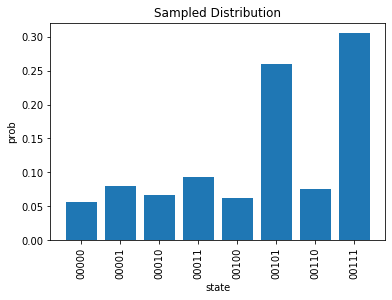

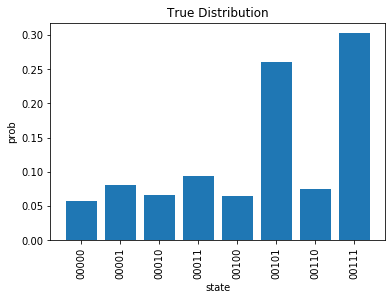

In [149]:
#convergence checking for V&V
n = 5
circ = Circuit(n)
m1 = randomStochMatrix(2)
g1 = Gate(m1,[0,1])

m2 = randomStochMatrix(1)
g2 = Gate(m2,[1])

m3 = randomStochMatrix(2)
g3 = Gate(m3,[0,2])

circ.addGate(g1)
circ.addGate(g2)
circ.addGate(g3)

print("Gates:")
print(circ)
print()

print("Wires:")
circ.printWires()

print()

print("Shot Distribution:")
dist = circ.shotsDist(10000)

distkeys = [k for k in dist]
distkeys.sort()
print(distkeys)
for k in distkeys:
    binformat = '0' + str(circ.n) + 'b'
    print(format(k, binformat) , " => ", dist[k])

print()
print("True Distribution:")
state = circ.fullStoch()
for k in distkeys:
    binformat = '0' + str(circ.n) + 'b'
    print(format(k,binformat), " => ", state[k])

stateHistogram(n,dist)
stateHistogram(n,state)

## Graph Example
random.seed(123)
np.random.seed(456)
print()
print("Graph Examples")
G_8 = randomConnectedGraph(8)
print("Graph (original):")
print(G_8.edges)

writeGraph(G_8,"graph_example.adjlist")
G_8_read = readGraph("graph_example.adjlist")

print("Graph (from file):")
print(G_8_read.edges)

G4 = randomConnectedGraph(4)
print("Cut Examples on Crossed Square Graph:")

vec = [1,1,1,1]
print(vec)
print("cut: ", graphCutBin(G4,vec))
print()

vec = [0,0,0,0]
print(vec)
print("cut: ", graphCutBin(G4,vec))
print()

vec = [1,1,0,0]
print(vec)
print("cut: ", graphCutBin(G4,vec))
print()

vec = [1,-1,1,-1]
print(vec)
print("cut: ", graphCutIsing(G4,vec))
print()

vec = [1,-1,-1,-1]
print(vec)
print("cut: ", graphCutIsing(G4,vec))

##Demonstrating ansatz circuits:
g_1pbit = getAnsatzGate1bit(0, np.pi/2)
g_2pbit = getAnsatzGate2bit(0,1,gamma = 100)

print(g_1pbit.matrix)
print(g_2pbit.matrix)

#Demonstrating graph embedding for K4 graph
k4 = randomConnectedGraph(4)
circ = getEmbeddedCircuit(k4,theta=np.pi/2, gamma=100)
circ.printWires()

#Demonstrating circuit appending
circ2 = getEmbeddedCircuit(k4,theta=0,gamma=10)
circ.appendCircuit(circ2)

print()
print()
circ.printWires()

In [131]:
colors = getEdgeColoring(G)
print(colors)
coldict = colors2dict(colors)
print(coldict.keys())
print(G.number_of_nodes())

{(0, 1): 0, (1, 2): 1, (0, 3): 1, (2, 3): 0, (0, 2): 2, (1, 3): 2}
dict_keys([0, 1, 2])
4


In [5]:
def genRand3Reg(n):
    assert(n >= k+1 and 3*n % 2 == 0), "Invalid number of vertices: k*n must be even and n >= k+1"
    #first construct a minimum spanning tree, then add random edges
    graph = randMinSpanningTree(n,k=k-1)
    
def randBinSpanningTree(n):
    vertices = np.array([v for v in range(n)])
    #np.random.shuffle(vertices)
    return generateBinTree(vertices)

def generateBinTree(arr):
    #generates a binary tree with a breadth first traversal
    arr = np.array(arr)
    assert(type(arr) == np.ndarray)
    graph = []
    length = arr.size
    for i in range(length):
        if(2*i+1 < length):
            graph.append(sorted((arr[i],arr[2*i+1])))
        if(2*i+2 < length):
            graph.append(sorted((arr[i],arr[2*i+2])))
    return graph

In [6]:
randBinSpanningTree(6)

[[0, 1], [0, 2], [1, 3], [1, 4], [2, 5]]

In [7]:
a = [0,1,2]
b = a.pop()
print(a)
print(b)

[0, 1]
2


In [132]:
def foo(x1,x2,x3):
    print(x1)
    print(x2)
    print(x3)
    print("it works")

x = [[1,2]]
foo(*x[0],3)

1
2
3
it works


KeyError: 2

In [ ]:
print(str(circ))
circ.printWires()

In [ ]:
stoch = circ.fullStoch()
for i in range(8):
    x = np.zeros((8,1))
    x[i] = 1
    a,b = np.where(np.dot(stoch,x) == 1)
    print(i , " => " , a[0])
    
print(stoch)
    

In [ ]:
np.transpose([1j])

In [ ]:
a = np.array([1,2])
b = np.array([2,4])
a + b

In [ ]:
#circ.expectationShots(100000)

In [ ]:
x = np.array([[0,1],[1,0]])
np.dot(x,x)

In [ ]:
def test_swap_alg(targs,n):
    targs = np.array(targs)
    tmpls = [i for i in range(n)]
    end = np.setdiff1d(tmpls,targs)
    ls = np.concatenate((targs,end))
    return ls

In [ ]:
print(test_swap_alg([3,1], 5))

In [ ]:
targs = [1, 3,4]
ls = [i for i in range(10)]

ls[targs in ls]

In [ ]:
hist = circ.shotsHistogram(1000)

In [ ]:
np.zeros((2,2))

In [9]:
x = np.array([[0, 1],[1,0]])
I = np.array([[1, 0],[0,1]])
np.dot(x,I)

array([[0, 1],
       [1, 0]])

True


/home/zmorrell/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


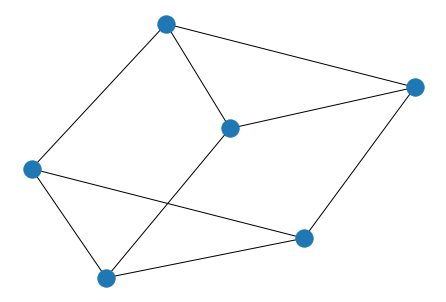

In [10]:
G = nx.generators.random_graphs.random_regular_graph(3,6)
print(nx.is_connected(G))
nx.draw(G)

In [11]:

print(G.nodes)
print(G.edges)
print(G_2.nodes)
G_2=readGraph("graph_example.adjlist")
print(G_2.edges)
sorted(G_2)

(nx.adj_matrix(G_2) - nx.adj_matrix(G)).todense()

[0, 1, 3, 4, 5, 2]
[(0, 1), (0, 5), (0, 3), (1, 3), (1, 4), (3, 2), (4, 5), (4, 2), (5, 2)]


NameError: name 'G_2' is not defined

In [12]:
sorted(G_2)

NameError: name 'G_2' is not defined

In [13]:
def myParsedGraph(path):
    file = open(path,'r')
    G = nx.Graph()
    for line in file:
        if line[0] == '#':
            continue
        else:
            line = line.strip('\n')
            labels = line.split(' ')
            G.add_node(int(labels[0]))
    file.seek(0)
    for line in file:
        if line[0] == '#':
            continue
        else:
            line = line.strip('\n')
            labels = line.split(' ')
            edges = [(int(labels[0]),int(labels[i])) for i in range(1,len(labels))]
            G.add_edges_from(edges)
    return G

In [14]:
G_mine = myParsedGraph("graph_example.adjlist")

In [15]:
G_mine.edges()

EdgeView([(0, 1), (0, 5), (0, 7), (1, 4), (1, 3), (2, 3), (2, 4), (2, 7), (3, 5), (4, 6), (5, 6), (6, 7)])

In [16]:
vec = np.array([[1, 0]])
mat = np.array([[1,1],[0,1]])

print(vec)
print((np.transpose(vec)))
print(mat)
print(np.matmul(mat,vec.T))
print(np.matmul(vec,np.matmul(mat,vec.T)))

[[1 0]]
[[1]
 [0]]
[[1 1]
 [0 1]]
[[1]
 [0]]
[[1]]


In [17]:
print(graphMatrix(G))
np.sum(graphMatrix(G))

  (0, 1)	1
  (0, 2)	1
  (0, 4)	1
  (1, 0)	1
  (1, 2)	1
  (1, 3)	1
  (2, 0)	1
  (2, 1)	1
  (2, 5)	1
  (3, 1)	1
  (3, 4)	1
  (3, 5)	1
  (4, 0)	1
  (4, 3)	1
  (4, 5)	1
  (5, 2)	1
  (5, 3)	1
  (5, 4)	1


18

In [18]:
graphCutBin(G,[1, 0, 1, 0,1,0,1,0])

ValueError: dimension mismatch

In [19]:
vec = np.array([[1,-1,1,-1,1,-1]])
mat = graphMatrix(G)

In [150]:
"""
def misra_gries(G):
    #assumes that it is operating on a 3-reg graph => Needs at most 4 colors with misra gries
    #use 0 to imply edge is uncolored
    #1-4 indicate the coloring of each edge
    #God help you if you have to debug this
    colors = ["-1", "0", "1", "2", "3"] #list of possible colors; -1 => uncolored
    vertices = G.nodes
    edges = G.edges
    edge_colors = dict()
    for edge in edges():
        edge_colors[edge] = colors[0]
    free_colors = dict()
    for vertex in vertices():
        free_colors[vertex] = colors[-4:]
        
    U = list(G.edges)
    
    for u,v in U:
        #start by creating a maximal fan
        print(edge_colors)
        print("(",u,",",v,")")
        if edge_colors[(u,v)] != "-1":
            continue
        F = []
        F.append(v)
        rem_edges = list(edges(u))
        rem_edges.remove((u,v))
        counter = 0;
        for _,b in rem_edges:
            if edge_colors[tuple(sorted((u,b)))] in free_colors[F[-1]] or edge_colors[tuple(sorted((u,b)))] == "-1":
                F.append(b)
            else:
                rem_edges.append(u,b);
            counter += 1
            if counter > 100:
                print("COUNTER EXCEEDED 100 ITERATIONS, MAY BE IN INFINITE LOOP")
                return
        print(F)
        
        #Maximal Fan has been constructed
        #Now need to invert cd_u path
        c = free_colors[u][0]
        d = free_colors[F[-1]][0]
        swap_color = c
        path_color = d
        u_prime = None
        v_prime = u
        path = [u]
        print("C: ", c, ", D: ", d)
        if(c != d):
            #constructing a cd_u path to invert
            while(True):
                u_prime = v_prime
                v_prime = None
                
                for edge in edges(u_prime):
                    print(edge_colors[tuple(sorted(edge))] == path_color)
                    if(edge_colors[tuple(sorted(edge))] == path_color):
                        if (edge[0] == u_prime):
                            v_prime = edge[1]
                        else:
                            v_prime = edge[0]
                        if path_color == c:
                            path_color = d
                        else:
                            path_color = c;
                        path.append(v_prime)
                        break
            
                if v_prime == None:
                    break
            #inverting the cd_u path
            while(len(path) > 1):
                edge_colors[tuple(sorted(path[:2]))] = swap_color
                free_colors[path[0]].remove(swap_color)
                free_colors[path[1]].remove(swap_color)
                if swap_color == c:
                    swap_color = d
                else:
                    swap_color = c
                free_colors[path[0]].append(swap_color)
                free_colors[path[0]].sort()
                free_colors[path[1]].append(swap_color)
                free_colors[path[1]].sort()
                path.pop(0)
        
        w = None
        #Find first w s.t. color d is free on w, and rotate that sub-fan.
        for w in range(1,len(F)+1):
            if(d in free_colors[F[w]]):
                break
        F_prime = F[:w+1]
        #rotate subfan
        for i in range(w+1):
            if(edge_colors[tuple(sorted((u,F[i])))] != "-1"):
                free_colors[F[i]].append(edge_colors[tuple(sorted((u,F[i])))])
                free_colors[F[i]].sort()
            print("line 98?")
            if(i != w and edge_colors[tuple(sorted((u,F[i+1])))] != "-1"):
                free_colors[F[i]].remove(edge_colors[tuple(sorted((u,F[i+1])))])
            if(i == w):
                edge_colors[tuple(sorted((u,F[i])))] = d
                free_colors[u].remove(d)
            else:
                edge_colors[tuple(sorted((u,F[i])))] = edge_colors[tuple(sorted((u,F[i+1])))]
        U.remove(tuple(sorted((u,F[w]))))
        if edge_colors[(u,v)] == "-1":
            U.append((u,v))
        #print(edge_colors)
    return edge_colors
"""


"""From Wikipedia:
    algorithm Misra & Gries edge coloring algorithm is
    input: A graph G.
    output: A proper coloring c of the edges of G.

    Let U := E(G)

    while U ≠ ∅ do
        Let (u, v) be any edge in U.  
        Let F[1:k] be a maximal fan of u starting at F[1] = v.
        Let c be a color that is free on u and d be a color that is free on F[k].  
        Invert the cdu path  
        Let w ∈ V(G) be such that w ∈ F, F' = [F[1]...w] is a fan and d is free on w.  
        Rotate F' and set c(u, w) = d.
        U := U − {(u, v)}
    end while
"""

"From Wikipedia:\n    algorithm Misra & Gries edge coloring algorithm is\n    input: A graph G.\n    output: A proper coloring c of the edges of G.\n\n    Let U := E(G)\n\n    while U ≠ ∅ do\n        Let (u, v) be any edge in U.  \n        Let F[1:k] be a maximal fan of u starting at F[1] = v.\n        Let c be a color that is free on u and d be a color that is free on F[k].  \n        Invert the cdu path  \n        Let w ∈ V(G) be such that w ∈ F, F' = [F[1]...w] is a fan and d is free on w.  \n        Rotate F' and set c(u, w) = d.\n        U := U − {(u, v)}\n    end while\n"

In [152]:
"""G = randomConnectedGraph(4)
edge_colors = misra_gries(G)
print(edge_colors)"""

'G = randomConnectedGraph(4)\nedge_colors = misra_gries(G)\nprint(edge_colors)'

In [ ]:
ls = [0]
for i in ls:
    ls.append(i+1)
    print(i)
    if i >10:
        break


In [ ]:
(1,2).remove(1)

In [ ]:
sorted((2,1))

In [ ]:
tempdict = {}
tempdict[(1,2)] = "yay"
tempdict[tuple(sorted([2,1]))]

In [ ]:
ls = [1,2,3]
ls.pop(0)
print(ls)

In [ ]:
ls = [(1,2), (3,4)]
ls.append((5,6))
print(ls)

In [ ]:
qwerty = None
for qwerty in [1,2,3,4,5]:
    if qwerty == 3:
        break
print(qwerty)

In [ ]:
lsdict = dict()
lsdict[1] = [1,2]
lsdict[1].append(3)
lsdict[1].sort()
print(lsdict[1])

In [42]:
max_color = 0
min_color = 100
for i in range(1000):
    G = randomConnectedGraph(100)
    lg = nx.generators.line.line_graph(G)
    colors = nx.coloring.equitable_color(lg,num_colors=4)
    for k in colors.keys():
        if colors[k] > max_color:
            max_color = colors[k]
        if colors[k] < min_color:
            min_color = colors[k]


print(max_color)
print(min_color)

NetworkXAlgorithmError: Graph has maximum degree 4, needs 5 (> 4) colors for guaranteed coloring.